In [1]:
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset as NetCDFFile
import math
from scipy.spatial import distance
from math import cos,sin,asin,sqrt
import random
from collections import Counter
import time

In [2]:
grid = NetCDFFile('/home/vanlaar/nns_python/NarvalDom2_NestE-R02B14_DOM03.nc')
clon_grid = grid.variables['clon'][:]
clat_grid = grid.variables['clat'][:]

In [3]:
cusize = NetCDFFile('/home/vanlaar/HDCP2data/TA_dom4/cusize_output_time44.nc')

nclouds_real = cusize.variables['nclouds'][0]
size = cusize.variables['size'][:]
cloudbin = cusize.variables['cloud_bin']

ncloud_bin = cusize.variables['ncloud_bin'][:]

ncloudsint = int(nclouds_real)
cloud_bin = cloudbin[0,0:ncloudsint]
filledbin = int(max(cloud_bin))



lmax = filledbin*size[0]
print lmax

counts = Counter(cloud_bin)
array_counts = np.array(list(counts.items()))
#print array_counts

binnr = array_counts[:,0].astype(int)

# Moet beter kunnen, maar alas:
ncloud_bin = np.zeros(filledbin)
for bb in range(0, filledbin):
    idx = np.where(cloud_bin[:]==bb+1)
    ncloud_bin[bb] = len(idx[0])


#Counter({1: 3, 8: 1, 3: 1, 4: 1, 5: 1})
probability = ncloud_bin/nclouds_real # probability of drawing from bin

nrbins = len(size)
nbins_range = np.arange(1,filledbin+1,1)




9604.026672363281


In [4]:
def haversine(x, y):
    radius = 6371000
    lon1, lat1 = x
    lon2, lat2 = y

    dlat = lat2-lat1
    dlon = lon2-lon1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*(sin(dlon/2))**2
    c = 2*asin(sqrt(a))
    distance = radius*c  #distance in m
    return distance



In [5]:
radius = 4000

In [6]:
def get_neighbours(ref_cell, radius):
    """ Returns the indeces of the cells that are within radius form the reference cell 
    """

    R = 6378.1 #Radius of the Earth
    d = radius/1000. #Distance in km

    maxlat_brng = np.deg2rad(0)
    maxlon_brng = np.deg2rad(90)
    minlat_brng = np.deg2rad(180)
    minlon_brng = np.deg2rad(270)

    lat1 = clat_grid[ref_cell]
    lon1 = clon_grid[ref_cell]

    maxlat = math.asin( math.sin(lat1)*math.cos(d/R) + math.cos(lat1)*math.sin(d/R)*math.cos(maxlat_brng))
    maxlon = lon1 + math.atan2(math.sin(maxlon_brng)*math.sin(d/R)*math.cos(lat1), math.cos(d/R)-math.sin(lat1)*math.sin(lat1))
    minlat = math.asin( math.sin(lat1)*math.cos(d/R) + math.cos(lat1)*math.sin(d/R)*math.cos(minlat_brng))
    minlon = lon1 + math.atan2(math.sin(minlon_brng)*math.sin(d/R)*math.cos(lat1), math.cos(d/R)-math.sin(lat1)*math.sin(lat1))

    # Gives you a square box around the reference cell:
    cells_box, = np.where((clon_grid < maxlon) & (clon_grid > minlon) & (clat_grid < maxlat) & (clat_grid > minlat))
        
    cellcentres = np.vstack((clon_grid[cells_box],clat_grid[cells_box])).T
    middlecell = np.array([[lon1,lat1]])

    # Compute distance for every point to the reference cell...
    distances = distance.cdist(middlecell, cellcentres, haversine)

    # ...and select those that are inside the given radius to obtain a circle around the reference cell.
    dist_idx = np.where(distances < d*1000)
    cells_circle = cells_box[dist_idx[1]]

    #print 'cells_circle:',cells_circle
    
    #neighbour_cell = cells[cells_circle]
    #neighbour_cell = cells[cells_circle[0]]
    #if neighbour_cell is not None:
        # This cell is occupied: store this index of the contained point
    #    neighbours.append(neighbour_cell)
    
    #neighbours = []
    #for dx, dy in dxdy:
    #    neighbour_coords = coords[0] + dx, coords[1] + dy
    #     if not (0 <= neighbour_coords[0] < nx and
    #             0 <= neighbour_coords[1] < ny):
    #         # We're off the grid: no neighbours here.
    #        continue
    #   neighbour_cell = cells[neighbour_coords]
    #     if neighbour_cell is not None:
    #         # This cell is occupied: store this index of the contained point    .
    #        neighbours.append(neighbour_cell)
    #return neighbours

        
    return cells_circle




#neighbour_cell = cells[neighbour_coords]
#        if neighbour_cell is not None:
#            # This cell is occupied: store this index of the contained point    .
#            neighbours.append(neighbour_cell)



In [7]:
cell_index = 150
#size = 10

cells_circle = get_neighbours(cell_index,300)
print cells_circle


[  148   149   150   151   152 10730 10732 10733]


In [53]:
def point_valid(pt, pt_size):
    """Is pt a valid point to emit as a sample?

    It must be no closer than r from any other point: check the cells in its
    immediate neighbourhood.

    """
    
    neighbours = get_neighbours(pt, pt_size+lmax) # radius must be 2*lmax
    for idx in neighbours:
    #for idx in samples:
        if idx in samples:
            size_idx = samples.index(idx)
            nearby_pt = idx
            nearby_size = sample_size[size_idx]
            # Squared distance between or candidate point, pt, and this nearby_pt.
            x = clon_grid[pt],clat_grid[pt]
            y = clon_grid[nearby_pt],clat_grid[nearby_pt]
            distance = haversine(x,y)
            if distance < pt_size + nearby_size:
                # The points are too close, so pt is not a candidate.
                return False
    # All points tested: if we're here, pt is valid
    return True



In [49]:
def get_point(ref_cell, ref_radius, k):
    """Try to find a candidate cell relative to ref_cell to emit in the sample.

    We draw up to k points from the annulus of inner radius r, outer radius 2r
    around the reference point, refpt. If none of them are suitable (because
    they're too close to existing points in the sample), return False.
    Otherwise, return the pt.

    """
    i = 0
    while i < k:
        #circle = get_neighbours(ref_cell, ref_radius+lmax)
        #keys = np.array(list(cells.keys()))
        #values = np.array(list(cells.values()))       
        #possible_cells = keys[circle]
        #possibilities = []
        #if values[possible_cells] is not None:
        #    possibilities.append(possible_cells)
        possibilities = get_neighbours(ref_cell, ref_radius+lmax) 
        pt = np.random.choice(possibilities)
        binnr = np.random.choice(nbins_range,1, True, probability)
        pt_size = binnr*size[0]
        if point_valid(pt, pt_size):
            return pt, pt_size
        i += 1
        
    # We failed to find a suitable point in the vicinity of refpt.
    return False, False

#test = get_point(150, 5)

In [55]:
ncells_grid = len(clon_grid)
ncells_range = np.arange(0,ncells_grid,1)
#random_cells = random.sample(ncells_range, nclouds)

cells = {index: None for index in ncells_range+1}

# Pick a random point to start with.
pt = np.random.choice(ncells_range)
samples = [pt]
binnr = np.random.choice(nbins_range, 1, True, probability)

sample_size = [np.float(binnr)*size[0]]
# Our first sample is indexed at 0 in the samples list...
cells[pt] = 0
# ... and it is active, in the sense that we're going to look for more points
# in its neighbourhood.
active = [0]

nsamples = 1
t0 = time.time()
# As long as there are points in the active list, keep trying to find samples.
while active:
    # choose a random "reference" point from the active list.
    idx = np.random.choice(active)
    refpt = samples[idx]
    # Try to pick a new point relative to the reference point.
    newpoint = get_point(refpt, sample_size[idx], 20)
    pt = newpoint[0]
    pt_size = newpoint[1]
    if pt:
        # Point pt is valid: add it to the samples list and mark it as active
        samples.append(pt)
        sample_size.append(pt_size)
        nsamples += 1
        active.append(len(samples)-1)
        cells[pt] = len(samples) - 1
    else:
        # We had to give up looking for valid points near refpt, so remove it
        # from the list of "active" points.
        active.remove(idx)
    if nsamples > 5000:
        break
        
print 'nsamples:',nsamples
elapsed = time.time() - t0
print "... done in %s." % time.strftime("%H:%M:%S", time.gmtime(elapsed))

KeyboardInterrupt: 

-0.9773667113560276


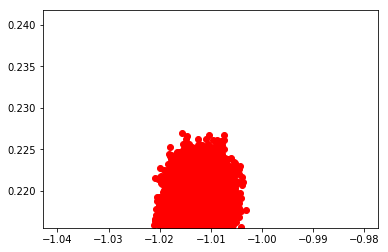

In [56]:
#plt.scatter(*zip(*samples), color='r', alpha=0.6, lw=0)
print max(clon_grid)
plt.scatter(clon_grid[samples],clat_grid[samples], color='r')
plt.xlim(min(clon_grid), max(clon_grid))
plt.ylim(min(clat_grid), max(clat_grid))
#plt.xlim(-0.990, -0.983)
#plt.ylim(0.225, 0.235)
#plt.axis('off')
plt.show()